<a href="https://colab.research.google.com/github/gemenerik/fastgate/blob/master/YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# find assigned GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr 30 15:24:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# reset all data and pull GitHub

import os
from getpass import getpass


%cd
os.chdir("/content/")
!sudo rm -r PyTorch-YOLOv3
!sudo rm -r fastgate
!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3

user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['BITBUCKET_AUTH'] = user + ':' + password

!git clone https://$BITBUCKET_AUTH@github.com/gemenerik/fastgate.git
os.chdir('PyTorch-YOLOv3')

In [0]:
# install required packages

%tensorflow_version 1.x #1.13.1
!sudo pip3 install -r requirements.txt

In [0]:
# mount Google drive to save/load trained models and downloaded files

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Optional: generate random train/val/test distribution
Default is with handpicked test images and a fixed seed on the train/val split. Run the following code to assess for a random pick of train/val/test images. Note that changing the split might affect the maximum allowable batch size.

In [0]:
import numpy as np
from shutil import copyfile

%cd
os.chdir("/content/fastgate")
!rm -R WashingtonOBRace/test_images
os.mkdir("WashingtonOBRace/test_images")
!rm -R WashingtonOBRace/images
os.mkdir("WashingtonOBRace/images")
!rm -R WashingtonOBRace/labels
os.mkdir("WashingtonOBRace/labels")

image_name_list = []
for file in os.listdir("WashingtonOBRace/original/"):
    if file.endswith(".png"):
        image_name_list.append(os.path.join(file))

number_test_images = 28

dataset_size = len(image_name_list)
indices = range(dataset_size)
test_idx = np.random.choice(indices, size=number_test_images, replace=False)
leftover_idx = (set(indices) - set(test_idx))
for i in test_idx:
  copyfile('WashingtonOBRace/original/' + str(image_name_list[i]), 'WashingtonOBRace/test_images/' + str(image_name_list[i]))
  print('WashingtonOBRace/original/' + str(image_name_list[i]))
for j in leftover_idx:
  copyfile('WashingtonOBRace/original/' + str(image_name_list[j]), 'WashingtonOBRace/images/' + str(image_name_list[j]))

!python3 label_generator.py

# Train custom

In [0]:
# create custom model config

%cd
os.chdir("/content/PyTorch-YOLOv3/config")
!bash create_custom_model.sh 1

In [0]:
# generate class names file (with only gate in it)

%cd
os.chdir("/content/PyTorch-YOLOv3/")
!truncate -s 0 'data/custom/classes.names'
file = open('data/custom/classes.names', 'w')
file.write('gate')
file.write('\n')
file.write('\n')

%cd
os.chdir("/content/PyTorch-YOLOv3/")
!truncate -s 0 'data/custom/classes.names'
file = open('data/custom/classes.names', 'w')
file.write('gate')
file.write('\n')
file.write('\n')

In [0]:
# clear images, labels and copy in new ones

%cd
os.chdir("/content/PyTorch-YOLOv3")
!rm -r data/custom/images/
!mkdir data/custom/images/
!rm -r data/samples/
!mkdir data/samples/
!rm -r data/custom/labels/
!mkdir data/custom/labels/
!rm data/custom/train.txt
!rm data/custom/valid.txt

%cd
os.chdir("/content/")
!cp -a fastgate/WashingtonOBRace/images/. PyTorch-YOLOv3/data/custom/images/
!cp -a fastgate/WashingtonOBRace/test_images/. PyTorch-YOLOv3/data/samples/
!cp -a fastgate/WashingtonOBRace/labels/. PyTorch-YOLOv3/data/custom/labels/
!cp -a fastgate/train.txt PyTorch-YOLOv3/data/custom/
!cp -a fastgate/valid.txt PyTorch-YOLOv3/data/custom/
# !cp -a gdrive/'My Drive'/fastgate/images/. PyTorch-YOLOv3/data/custom/images/
# !cp -a gdrive/'My Drive'/fastgate/labels/. PyTorch-YOLOv3/data/custom/labels/
# !cp -a gdrive/'My Drive'/fastgate/train.txt PyTorch-YOLOv3/data/custom/
# !cp -a gdrive/'My Drive'/fastgate/valid.txt PyTorch-YOLOv3/data/custom/

In [0]:
# optional; switch to tiny cfg

%cd
os.chdir("/content")
!cp -a fastgate/yolov3-custom.cfg PyTorch-YOLOv3/config/yolov3-custom.cfg


In [0]:
# optional; clear checkpoints

%cd
os.chdir("/content/PyTorch-YOLOv3/checkpoints")
list = os.listdir()
count = 0
for i in list:
  print(i)
  os.remove(i)
print(os.listdir())

In [0]:
# fixing error in YOLOv3, issue #178
# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/178

%cd
os.chdir("/content")
!rm PyTorch-YOLOv3/test.py
!cp fastgate/test.py PyTorch-YOLOv3/test.py

In [0]:
# train

%cd
os.chdir("/content/PyTorch-YOLOv3")
# -W ignore
!python3 train.py --model_def config/yolov3-custom.cfg --data_config config/custom.data --batch_size 8 --epochs 400 --img_size 384 --checkpoint_interval 5

Common train errors:

Solve valueerror not enough values to unpack (expected 3, got 0);
https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/178

List index out of range;
check if classes.names has all classes then an empty line, don't generate it twice without deleting

In [0]:
# download selected checkpoint

%cd
from google.colab import files
os.chdir("/content/PyTorch-YOLOv3/checkpoints")
files.download('yolov3_ckpt_390.pth')

In [0]:
%load_ext tensorboard

In [0]:
# show tensorboard logs

%tensorboard --logdir logs

In [0]:
# save a copy of a checkpoint to drive

%cd
os.chdir("/content")
!cp -v PyTorch-YOLOv3/checkpoints/yolov3_ckpt_50.pth gdrive/'My Drive'/fastgate/checkpoints/yolov3_tiny_50.pth

In [0]:
# resume training

%cd
os.chdir("/content/PyTorch-YOLOv3")
# -W ignore
!python3 train.py --model_def config/yolov3-custom.cfg --data_config config/custom.data --batch_size 8 --epochs 75 --pretrained_weights checkpoints/yolov3_ckpt_125.pth

#Inference

In [0]:
# load checkpoint from drive

%cd
os.chdir("/content")
os.mkdir("/content/PyTorch-YOLOv3/checkpoints")
!cp -v gdrive/'My Drive'/fastgate/checkpoints/yolov3_big_395.pth PyTorch-YOLOv3/checkpoints/yolov3_big_395.pth
!cp -v gdrive/'My Drive'/fastgate/checkpoints/yolov3_tiny_360.pth PyTorch-YOLOv3/checkpoints/yolov3_tiny_360.pth

In [0]:
# test on samples (test image folder)

%cd
os.chdir("/content/PyTorch-YOLOv3")
!python3 detect.py --model_def config/yolov3-custom.cfg --weights_path checkpoints/yolov3_big_395.pth --image_folder data/samples/ --class_path data/custom/classes.names --conf_thres=0.9
# !python3 detect.py --model_def config/yolov3-custom.cfg --weights_path checkpoints/yolov3_tiny_360.pth --image_folder data/samples/ --class_path data/custom/classes.names --conf_thres=0.3

/root
['img_9.png', 'img_42.png', 'img_400.png', 'img_6.png', 'img_180.png', 'img_325.png', 'img_194.png', 'img_154.png', 'img_438.png', 'img_205.png', 'img_382.png', 'img_266.png', 'img_370.png', 'img_117.png', 'img_74.png', 'img_119.png', 'img_54.png', 'img_253.png', 'img_11.png', 'img_110.png', 'img_126.png', 'img_63.png', 'img_34.png', 'img_138.png', 'img_243.png', 'img_397.png', 'img_387.png', 'img_31.png']
img_9.png
img_42.png
img_400.png
img_6.png
img_180.png
img_325.png
img_194.png
img_154.png
img_438.png
img_205.png
img_382.png
img_266.png
img_370.png
img_117.png
img_74.png
img_119.png
img_54.png
img_253.png
img_11.png
img_110.png
img_126.png
img_63.png
img_34.png
img_138.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


img_243.png
img_397.png
img_387.png
img_31.png


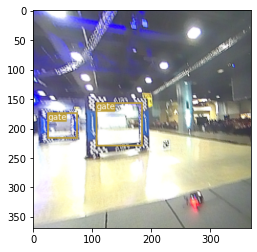

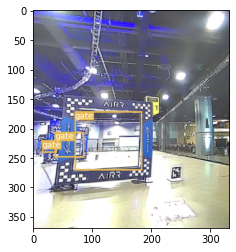

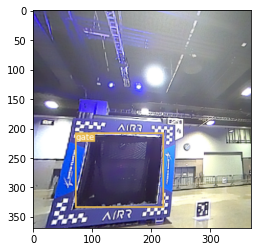

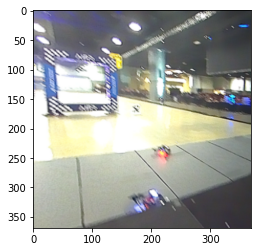

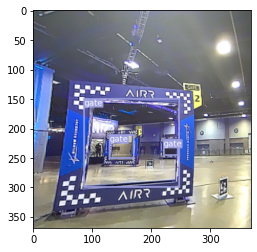

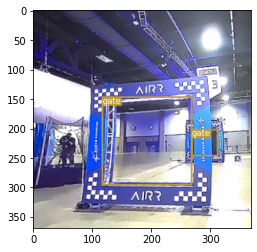

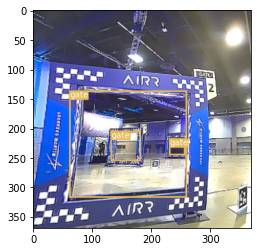

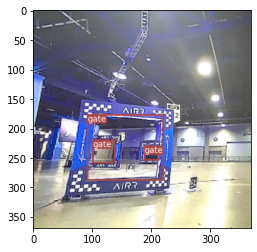

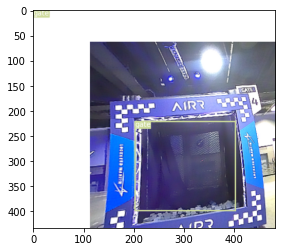

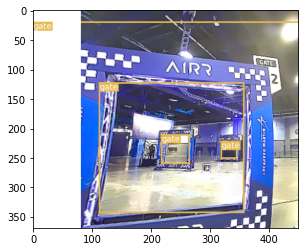

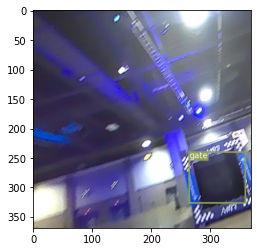

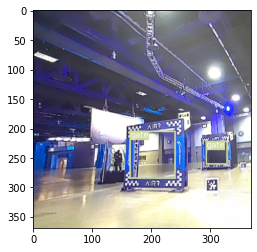

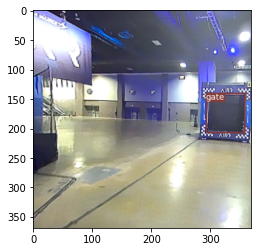

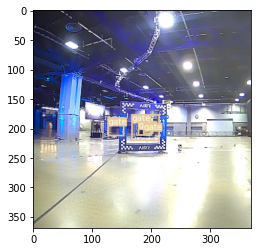

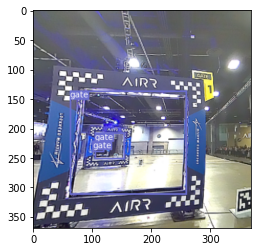

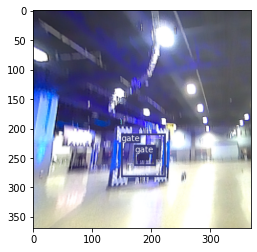

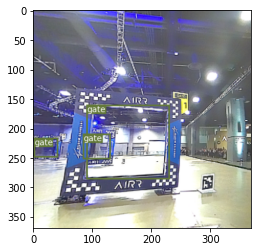

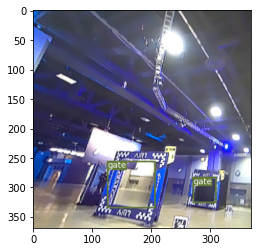

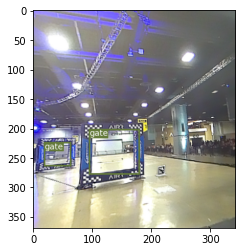

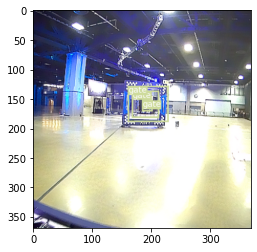

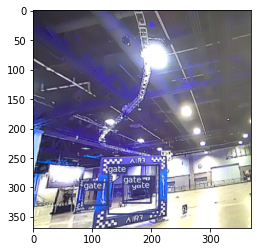

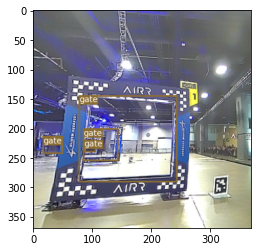

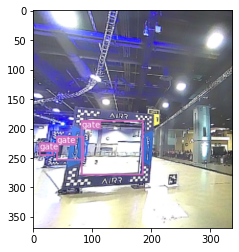

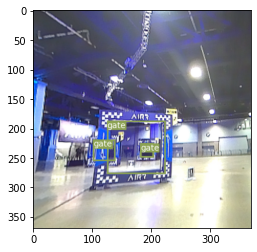

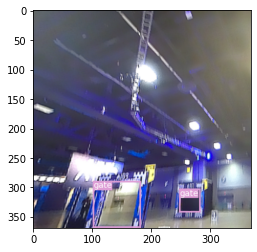

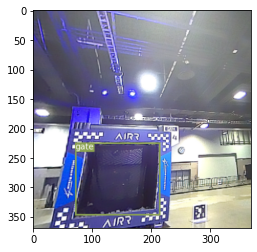

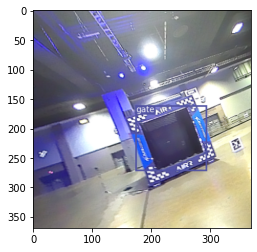

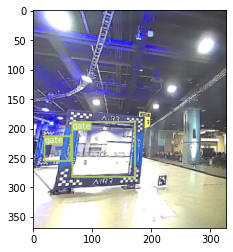

In [13]:
# visualize results

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow, figure
%matplotlib inline

%cd
os.chdir("/content/PyTorch-YOLOv3/output")
image_list = os.listdir()
print(image_list)
for image in image_list:
  print(image)
  im = mpimg.imread(image)
  figure()
  imshow(im)

In [0]:
# download result images

!zip -r /content/PyTorch-YOLOv3/output.zip /content/PyTorch-YOLOv3/output
from google.colab import files
files.download("/content/PyTorch-YOLOv3/output.zip")

# Inference evaluation

In [0]:
# import required packages

%cd
os.chdir("/content/PyTorch-YOLOv3")
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *

import os
import sys
import time
import datetime
import argparse
import tqdm
import numpy as np
import itertools

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

%cd
os.chdir("/content/fastgate")
from alt_test import evaluate

In [0]:
# import alternative test python file (required)

%cd
os.chdir("/content")
# !rm PyTorch-YOLOv3/alt_test.py
!cp fastgate/alt_test.py PyTorch-YOLOv3/alt_test.py

In [0]:
# import test images, labels, configs

%cd
os.chdir("/content/PyTorch-YOLOv3")
!mkdir data/test
!rm -r data/test/labels/
!mkdir data/test/labels/
!rm -r data/test/images/
!mkdir data/test/images/
!cp -a data/samples/. data/test/images

%cd
os.chdir("/content/")
!cp -a fastgate/labels/. PyTorch-YOLOv3/data/test/labels/

%cd
os.chdir("/content/PyTorch-YOLOv3/")
!truncate -s 0 'config/test.data'
file = open('config/test.data', 'w')
file.write('classes= 1 \ntrain=data/test/train.txt \nvalid=data/test/valid.txt \nnames=data/test/classes.names')

%cd
os.chdir("/content/PyTorch-YOLOv3/")
!truncate -s 0 'config/test.data'
file = open('config/test.data', 'w')
file.write('classes= 1 \n train=data/test/train.txt \n valid=data/test/valid.txt \n names=data/test/classes.names')

In [0]:
# write valid.txt, that gives the path to the correct images

%cd
os.chdir("/content/PyTorch-YOLOv3/")
!truncate -s 0 'data/test/valid.txt'
file = open('data/test/valid.txt', 'w')
for image in os.listdir('data/samples'):
  file.write('data/test/images/' + image + '\n')

%cd
os.chdir("/content/PyTorch-YOLOv3/")
!truncate -s 0 'data/test/valid.txt'
file = open('data/test/valid.txt', 'w')
for image in os.listdir('data/samples'):
  file.write('data/test/images/' + image + '\n')

In [0]:
# run inference on all test images, graph results for varying thresholds

%cd
os.chdir('/content/PyTorch-YOLOv3')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# select checkpoint;
# pretrained_weights = 'checkpoints/yolov3_tiny_360.pth'
pretrained_weights = 'checkpoints/yolov3_big_395.pth'
model_def = 'config/yolov3-custom.cfg'
data_config = 'config/test.data'

data_config = parse_data_config(data_config)
valid_path = data_config["valid"]
print(valid_path)

model = Darknet(model_def).to(device)
model.apply(weights_init_normal)

model.load_state_dict(torch.load(pretrained_weights))

# model/threshold/graphing settings
nms_thres = 0.5
img_size = 384
iou_thres_list = np.round(np.arange(0.4, .9, 0.1), 1)
conf_thres_list = np.arange(0.05, 1.0, 0.1)
# conf_thres_list = [0.90, 0.95]
marker = itertools.cycle(('.', 'x')) 

plt.figure(dpi=500)
for iou_thres in iou_thres_list:
  false_positive_average_list = []
  true_positive_rate_list = []
  for conf_thres in conf_thres_list:
    precision, recall, AP, f1, ap_class, true_positives = evaluate(
                    model,
                    path=valid_path,
                    iou_thres=iou_thres,
                    conf_thres=conf_thres,
                    nms_thres=nms_thres,
                    img_size=img_size,
                    batch_size=1,
                )
    number_of_gates = 64 # known
    number_of_images = 28 # "

    true_positive = sum(true_positives)
    true_positive_rate = true_positive / number_of_gates
    true_positive_rate_list.append(true_positive_rate)

    false_positive = len(true_positives) - sum(true_positives)
    false_positive_average = false_positive / number_of_images
    false_positive_average_list.append(false_positive_average)
  true_positive_rate_list.append(0)
  false_positive_average_list.append(0)
  plt.scatter(false_positive_average_list, true_positive_rate_list, marker=next(marker))
  label = 'IoU ' + str(iou_thres)
  plt.plot(false_positive_average_list, true_positive_rate_list, label=label)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0, 1.1)
plt.xlim(left=0, right=1)
plt.legend()
plt.grid()
plt.show()

# print('\n')
# print(f"---- mAP {AP.mean()}")
# print(true_positives)
# print('Number of detections; ', len(true_positives))
# print('Number of true positives', sum(true_positives))
# print('Number of false positives', len(true_positives) - sum(true_positives))

# Appendix A
*Train/test/val images*

### Hand-picked test images


**Test**

```
img_6
3
11
31
34
42
54
63
74
110
117
119
126
138
154
180
194
205
243
253
266
325
370
382
387
397
400
438
```

**Train**
```
data/custom/images/img_159.png
data/custom/images/img_137.png
data/custom/images/img_435.png
data/custom/images/img_270.png
data/custom/images/img_187.png
data/custom/images/img_8.png
data/custom/images/img_271.png
data/custom/images/img_315.png
data/custom/images/img_256.png
data/custom/images/img_24.png
data/custom/images/img_166.png
data/custom/images/img_61.png
data/custom/images/img_238.png
data/custom/images/img_203.png
data/custom/images/img_175.png
data/custom/images/img_255.png
data/custom/images/img_259.png
data/custom/images/img_415.png
data/custom/images/img_296.png
data/custom/images/img_283.png
data/custom/images/img_191.png
data/custom/images/img_404.png
data/custom/images/img_58.png
data/custom/images/img_280.png
data/custom/images/img_303.png
data/custom/images/img_192.png
data/custom/images/img_114.png
data/custom/images/img_47.png
data/custom/images/img_263.png
data/custom/images/img_273.png
data/custom/images/img_330.png
data/custom/images/img_322.png
data/custom/images/img_424.png
data/custom/images/img_254.png
data/custom/images/img_135.png
data/custom/images/img_265.png
data/custom/images/img_173.png
data/custom/images/img_385.png
data/custom/images/img_276.png
data/custom/images/img_410.png
data/custom/images/img_196.png
data/custom/images/img_33.png
data/custom/images/img_268.png
data/custom/images/img_291.png
data/custom/images/img_130.png
data/custom/images/img_261.png
data/custom/images/img_251.png
data/custom/images/img_27.png
data/custom/images/img_168.png
data/custom/images/img_319.png
data/custom/images/img_293.png
data/custom/images/img_323.png
data/custom/images/img_314.png
data/custom/images/img_148.png
data/custom/images/img_310.png
data/custom/images/img_260.png
data/custom/images/img_147.png
data/custom/images/img_164.png
data/custom/images/img_372.png
data/custom/images/img_298.png
data/custom/images/img_197.png
data/custom/images/img_182.png
data/custom/images/img_165.png
data/custom/images/img_237.png
data/custom/images/img_204.png
data/custom/images/img_232.png
data/custom/images/img_413.png
data/custom/images/img_258.png
data/custom/images/img_190.png
data/custom/images/img_152.png
data/custom/images/img_371.png
data/custom/images/img_419.png
data/custom/images/img_156.png
data/custom/images/img_321.png
data/custom/images/img_112.png
data/custom/images/img_386.png
data/custom/images/img_246.png
data/custom/images/img_62.png
data/custom/images/img_199.png
data/custom/images/img_396.png
data/custom/images/img_184.png
data/custom/images/img_179.png
data/custom/images/img_391.png
data/custom/images/img_376.png
data/custom/images/img_10.png
data/custom/images/img_36.png
data/custom/images/img_45.png
data/custom/images/img_149.png
data/custom/images/img_299.png
data/custom/images/img_436.png
data/custom/images/img_320.png
data/custom/images/img_202.png
data/custom/images/img_139.png
data/custom/images/img_327.png
data/custom/images/img_72.png
data/custom/images/img_67.png
data/custom/images/img_412.png
data/custom/images/img_426.png
data/custom/images/img_234.png
data/custom/images/img_115.png
data/custom/images/img_297.png
data/custom/images/img_150.png
data/custom/images/img_189.png
data/custom/images/img_399.png
data/custom/images/img_48.png
data/custom/images/img_23.png
data/custom/images/img_277.png
data/custom/images/img_158.png
data/custom/images/img_131.png
data/custom/images/img_28.png
data/custom/images/img_388.png
data/custom/images/img_59.png
data/custom/images/img_252.png
data/custom/images/img_406.png
data/custom/images/img_241.png
data/custom/images/img_153.png
data/custom/images/img_417.png
data/custom/images/img_177.png
data/custom/images/img_155.png
data/custom/images/img_302.png
data/custom/images/img_128.png
data/custom/images/img_186.png
data/custom/images/img_134.png
data/custom/images/img_146.png
data/custom/images/img_170.png
data/custom/images/img_434.png
data/custom/images/img_25.png
data/custom/images/img_53.png
data/custom/images/img_29.png
data/custom/images/img_401.png
data/custom/images/img_316.png
data/custom/images/img_12.png
data/custom/images/img_433.png
data/custom/images/img_282.png
data/custom/images/img_125.png
data/custom/images/img_307.png
data/custom/images/img_429.png
data/custom/images/img_132.png
data/custom/images/img_113.png
data/custom/images/img_278.png
data/custom/images/img_183.png
data/custom/images/img_60.png
data/custom/images/img_402.png
data/custom/images/img_305.png
data/custom/images/img_136.png
data/custom/images/img_13.png
data/custom/images/img_14.png
data/custom/images/img_185.png
data/custom/images/img_289.png
data/custom/images/img_26.png
data/custom/images/img_304.png
data/custom/images/img_140.png
data/custom/images/img_257.png
data/custom/images/img_373.png
data/custom/images/img_284.png
data/custom/images/img_141.png
data/custom/images/img_22.png
data/custom/images/img_239.png
data/custom/images/img_294.png
data/custom/images/img_143.png
data/custom/images/img_235.png
data/custom/images/img_287.png
data/custom/images/img_326.png
data/custom/images/img_264.png
data/custom/images/img_37.png
data/custom/images/img_145.png
data/custom/images/img_240.png
data/custom/images/img_262.png
data/custom/images/img_418.png
data/custom/images/img_398.png
data/custom/images/img_56.png
data/custom/images/img_35.png
data/custom/images/img_250.png
data/custom/images/img_430.png
data/custom/images/img_236.png
data/custom/images/img_65.png
data/custom/images/img_200.png
data/custom/images/img_301.png
data/custom/images/img_52.png
data/custom/images/img_407.png
data/custom/images/img_151.png
data/custom/images/img_39.png
data/custom/images/img_306.png
data/custom/images/img_267.png
data/custom/images/img_308.png
data/custom/images/img_290.png
data/custom/images/img_311.png
data/custom/images/img_46.png
data/custom/images/img_176.png
data/custom/images/img_43.png
data/custom/images/img_41.png
data/custom/images/img_247.png
data/custom/images/img_20.png
data/custom/images/img_408.png
data/custom/images/img_160.png
data/custom/images/img_69.png
data/custom/images/img_374.png
data/custom/images/img_127.png
data/custom/images/img_389.png
data/custom/images/img_68.png
data/custom/images/img_249.png
data/custom/images/img_403.png
data/custom/images/img_167.png
data/custom/images/img_144.png
data/custom/images/img_195.png
data/custom/images/img_116.png
data/custom/images/img_423.png
data/custom/images/img_405.png
data/custom/images/img_181.png
data/custom/images/img_300.png
data/custom/images/img_427.png
data/custom/images/img_292.png
data/custom/images/img_248.png
data/custom/images/img_392.png
data/custom/images/img_18.png
data/custom/images/img_169.png
data/custom/images/img_157.png
data/custom/images/img_409.png
data/custom/images/img_124.png
data/custom/images/img_242.png
data/custom/images/img_285.png
data/custom/images/img_279.png
data/custom/images/img_329.png
data/custom/images/img_198.png
data/custom/images/img_414.png
data/custom/images/img_420.png
data/custom/images/img_55.png
data/custom/images/img_312.png
data/custom/images/img_286.png
data/custom/images/img_66.png
data/custom/images/img_21.png
data/custom/images/img_171.png
data/custom/images/img_421.png
data/custom/images/img_428.png
data/custom/images/img_317.png
data/custom/images/img_71.png
data/custom/images/img_73.png
data/custom/images/img_425.png
data/custom/images/img_390.png
data/custom/images/img_393.png
data/custom/images/img_269.png
data/custom/images/img_274.png
data/custom/images/img_272.png
data/custom/images/img_178.png
data/custom/images/img_331.png
data/custom/images/img_133.png
data/custom/images/img_328.png
data/custom/images/img_161.png
```

**Valid**
```
data/custom/images/img_313.png
data/custom/images/img_432.png
data/custom/images/img_57.png
data/custom/images/img_288.png
data/custom/images/img_32.png
data/custom/images/img_233.png
data/custom/images/img_422.png
data/custom/images/img_384.png
data/custom/images/img_416.png
data/custom/images/img_431.png
data/custom/images/img_129.png
data/custom/images/img_383.png
data/custom/images/img_324.png
data/custom/images/img_281.png
data/custom/images/img_275.png
data/custom/images/img_375.png
data/custom/images/img_411.png
data/custom/images/img_174.png
data/custom/images/img_51.png
data/custom/images/img_142.png
data/custom/images/img_163.png
data/custom/images/img_193.png
data/custom/images/img_188.png
data/custom/images/img_162.png
data/custom/images/img_19.png
data/custom/images/img_111.png
data/custom/images/img_318.png
data/custom/images/img_64.png
data/custom/images/img_309.png
data/custom/images/img_437.png
data/custom/images/img_295.png
data/custom/images/img_172.png
```

### Random initialization



**Test**


```
img_135
173
189
194
239
255
39
400
402
404
426
57
```



**Train**
```
data/custom/images/img_391.png
data/custom/images/img_286.png
data/custom/images/img_63.png
data/custom/images/img_284.png
data/custom/images/img_324.png
data/custom/images/img_280.png
data/custom/images/img_185.png
data/custom/images/img_27.png
data/custom/images/img_46.png
data/custom/images/img_393.png
data/custom/images/img_152.png
data/custom/images/img_236.png
data/custom/images/img_159.png
data/custom/images/img_180.png
data/custom/images/img_390.png
data/custom/images/img_204.png
data/custom/images/img_429.png
data/custom/images/img_300.png
data/custom/images/img_66.png
data/custom/images/img_318.png
data/custom/images/img_115.png
data/custom/images/img_148.png
data/custom/images/img_413.png
data/custom/images/img_145.png
data/custom/images/img_290.png
data/custom/images/img_182.png
data/custom/images/img_291.png
data/custom/images/img_383.png
data/custom/images/img_289.png
data/custom/images/img_419.png
data/custom/images/img_302.png
data/custom/images/img_326.png
data/custom/images/img_434.png
data/custom/images/img_264.png
data/custom/images/img_315.png
data/custom/images/img_165.png
data/custom/images/img_328.png
data/custom/images/img_293.png
data/custom/images/img_385.png
data/custom/images/img_327.png
data/custom/images/img_237.png
data/custom/images/img_67.png
data/custom/images/img_305.png
data/custom/images/img_406.png
data/custom/images/img_281.png
data/custom/images/img_203.png
data/custom/images/img_119.png
data/custom/images/img_51.png
data/custom/images/img_370.png
data/custom/images/img_188.png
data/custom/images/img_240.png
data/custom/images/img_418.png
data/custom/images/img_274.png
data/custom/images/img_186.png
data/custom/images/img_147.png
data/custom/images/img_175.png
data/custom/images/img_249.png
data/custom/images/img_153.png
data/custom/images/img_275.png
data/custom/images/img_269.png
data/custom/images/img_169.png
data/custom/images/img_166.png
data/custom/images/img_321.png
data/custom/images/img_155.png
data/custom/images/img_397.png
data/custom/images/img_283.png
data/custom/images/img_285.png
data/custom/images/img_436.png
data/custom/images/img_47.png
data/custom/images/img_131.png
data/custom/images/img_45.png
data/custom/images/img_28.png
data/custom/images/img_162.png
data/custom/images/img_384.png
data/custom/images/img_202.png
data/custom/images/img_387.png
data/custom/images/img_310.png
data/custom/images/img_43.png
data/custom/images/img_252.png
data/custom/images/img_276.png
data/custom/images/img_433.png
data/custom/images/img_161.png
data/custom/images/img_304.png
data/custom/images/img_171.png
data/custom/images/img_10.png
data/custom/images/img_192.png
data/custom/images/img_238.png
data/custom/images/img_279.png
data/custom/images/img_325.png
data/custom/images/img_374.png
data/custom/images/img_19.png
data/custom/images/img_150.png
data/custom/images/img_410.png
data/custom/images/img_197.png
data/custom/images/img_253.png
data/custom/images/img_414.png
data/custom/images/img_191.png
data/custom/images/img_430.png
data/custom/images/img_329.png
data/custom/images/img_53.png
data/custom/images/img_151.png
data/custom/images/img_392.png
data/custom/images/img_54.png
data/custom/images/img_200.png
data/custom/images/img_422.png
data/custom/images/img_129.png
data/custom/images/img_31.png
data/custom/images/img_198.png
data/custom/images/img_73.png
data/custom/images/img_373.png
data/custom/images/img_25.png
data/custom/images/img_282.png
data/custom/images/img_167.png
data/custom/images/img_431.png
data/custom/images/img_303.png
data/custom/images/img_14.png
data/custom/images/img_158.png
data/custom/images/img_157.png
data/custom/images/img_407.png
data/custom/images/img_205.png
data/custom/images/img_288.png
data/custom/images/img_278.png
data/custom/images/img_424.png
data/custom/images/img_432.png
data/custom/images/img_273.png
data/custom/images/img_141.png
data/custom/images/img_48.png
data/custom/images/img_405.png
data/custom/images/img_156.png
data/custom/images/img_287.png
data/custom/images/img_386.png
data/custom/images/img_247.png
data/custom/images/img_257.png
data/custom/images/img_330.png
data/custom/images/img_388.png
data/custom/images/img_125.png
data/custom/images/img_243.png
data/custom/images/img_427.png
data/custom/images/img_311.png
data/custom/images/img_32.png
data/custom/images/img_199.png
data/custom/images/img_246.png
data/custom/images/img_69.png
data/custom/images/img_132.png
data/custom/images/img_259.png
data/custom/images/img_267.png
data/custom/images/img_277.png
data/custom/images/img_139.png
data/custom/images/img_292.png
data/custom/images/img_149.png
data/custom/images/img_160.png
data/custom/images/img_68.png
data/custom/images/img_235.png
data/custom/images/img_371.png
data/custom/images/img_72.png
data/custom/images/img_9.png
data/custom/images/img_272.png
data/custom/images/img_144.png
data/custom/images/img_437.png
data/custom/images/img_316.png
data/custom/images/img_296.png
data/custom/images/img_26.png
data/custom/images/img_372.png
data/custom/images/img_168.png
data/custom/images/img_421.png
data/custom/images/img_306.png
data/custom/images/img_136.png
data/custom/images/img_117.png
data/custom/images/img_64.png
data/custom/images/img_416.png
data/custom/images/img_128.png
data/custom/images/img_420.png
data/custom/images/img_24.png
data/custom/images/img_170.png
data/custom/images/img_52.png
data/custom/images/img_142.png
data/custom/images/img_112.png
data/custom/images/img_13.png
data/custom/images/img_415.png
data/custom/images/img_294.png
data/custom/images/img_55.png
data/custom/images/img_183.png
data/custom/images/img_37.png
data/custom/images/img_146.png
data/custom/images/img_34.png
data/custom/images/img_111.png
data/custom/images/img_187.png
data/custom/images/img_271.png
data/custom/images/img_60.png
data/custom/images/img_134.png
data/custom/images/img_71.png
data/custom/images/img_398.png
data/custom/images/img_20.png
data/custom/images/img_382.png
data/custom/images/img_164.png
data/custom/images/img_179.png
data/custom/images/img_260.png
data/custom/images/img_322.png
data/custom/images/img_181.png
data/custom/images/img_110.png
data/custom/images/img_33.png
data/custom/images/img_319.png
data/custom/images/img_309.png
data/custom/images/img_8.png
data/custom/images/img_251.png
data/custom/images/img_127.png
data/custom/images/img_130.png
data/custom/images/img_408.png
data/custom/images/img_308.png
data/custom/images/img_396.png
data/custom/images/img_163.png
data/custom/images/img_113.png
data/custom/images/img_331.png
data/custom/images/img_133.png
data/custom/images/img_114.png
data/custom/images/img_375.png
data/custom/images/img_21.png
data/custom/images/img_143.png
data/custom/images/img_298.png
data/custom/images/img_195.png
data/custom/images/img_193.png
data/custom/images/img_409.png
data/custom/images/img_317.png
data/custom/images/img_323.png
data/custom/images/img_265.png
data/custom/images/img_307.png
data/custom/images/img_190.png
data/custom/images/img_58.png
data/custom/images/img_263.png
data/custom/images/img_312.png
data/custom/images/img_176.png
data/custom/images/img_65.png
data/custom/images/img_41.png
data/custom/images/img_233.png
data/custom/images/img_297.png
data/custom/images/img_242.png
data/custom/images/img_412.png
data/custom/images/img_140.png
data/custom/images/img_126.png
data/custom/images/img_438.png
```

**Valid**
```
data/custom/images/img_234.png
data/custom/images/img_299.png
data/custom/images/img_314.png
data/custom/images/img_376.png
data/custom/images/img_254.png
data/custom/images/img_435.png
data/custom/images/img_36.png
data/custom/images/img_270.png
data/custom/images/img_258.png
data/custom/images/img_22.png
data/custom/images/img_178.png
data/custom/images/img_320.png
data/custom/images/img_74.png
data/custom/images/img_137.png
data/custom/images/img_172.png
data/custom/images/img_11.png
data/custom/images/img_268.png
data/custom/images/img_62.png
data/custom/images/img_423.png
data/custom/images/img_262.png
data/custom/images/img_256.png
data/custom/images/img_232.png
data/custom/images/img_401.png
data/custom/images/img_154.png
data/custom/images/img_389.png
data/custom/images/img_61.png
data/custom/images/img_116.png
data/custom/images/img_403.png
data/custom/images/img_313.png
data/custom/images/img_12.png
data/custom/images/img_23.png
data/custom/images/img_124.png
data/custom/images/img_399.png
data/custom/images/img_6.png
data/custom/images/img_56.png
data/custom/images/img_174.png
data/custom/images/img_42.png
data/custom/images/img_411.png
data/custom/images/img_177.png
data/custom/images/img_301.png
data/custom/images/img_29.png
data/custom/images/img_266.png
data/custom/images/img_35.png
data/custom/images/img_184.png
data/custom/images/img_138.png
data/custom/images/img_417.png
data/custom/images/img_196.png
data/custom/images/img_295.png
data/custom/images/img_428.png
data/custom/images/img_241.png
data/custom/images/img_59.png
data/custom/images/img_248.png
data/custom/images/img_18.png
data/custom/images/img_261.png
data/custom/images/img_250.png
data/custom/images/img_425.png
```